In [40]:

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import helpers.images.offline_image_helperr as offline_image_helper
import helpers.images.offline_image_helper as offline_image_helperr
from helpers.plottin import basic_plotting
from tensorflow.keras.applications import vgg19

In [41]:
content_loc = r'C:\Users\Данила\Desktop\Мои файлы\Second year\Python\Python 2 semester 2 year\Project\NST\eagle4.jpg'
style_loc = r'C:\Users\Данила\Desktop\Мои файлы\Second year\Python\Python 2 semester 2 year\Project\NST\wave.jpg'

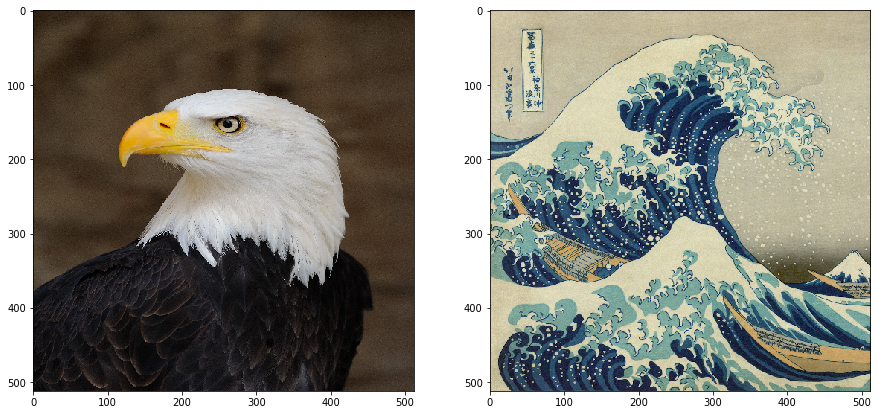

In [42]:

content_img = offline_image_helper.load_image(content_loc,target_size=(512,512))
style_img = offline_image_helper.load_image(style_loc,target_size=(512,512))
basic_plotting.plot_image_grid([content_img,style_img])

In [43]:
base_model=vgg19.VGG19(include_top=False,weights="imagenet",)

In [44]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [45]:
CONTENT_LAYERS = ["block5_conv2"]
OUTPUT_LAYERS = ["block4_conv1","block4_conv2","block4_conv3","block4_conv4"]

In [46]:

def make_model(include_full= False,input_shape =None):
    if include_full:
        base_model=vgg19.VGG19(include_top=True,weights="imagenet")
        return base_model      
    if input_shape!=None:
        base_model=vgg19.VGG19(include_top=False,input_shape=input_shape,weights="imagenet")
    else:
        base_model=vgg19.VGG19(include_top=False,weights="imagenet")
    base_model.trainable= False
    content_layers =CONTENT_LAYERS
    style_layers = OUTPUT_LAYERS
    output_layers = [base_model.get_layer(layer).output for layer in (content_layers+style_layers)]
    return tf.keras.models.Model(base_model.input,output_layers)

In [47]:
content_img_noised = content_img + np.random.randn(*content_img.shape)*10
content_img_noised = content_img_noised.astype("float32")

In [48]:
processed_wave = vgg19.preprocess_input(np.expand_dims(style_img,axis=0))
processed_golden_gate = vgg19.preprocess_input(np.expand_dims(content_img,axis=0))

In [49]:
VGG_BIASES = vgg19.preprocess_input((np.zeros((3))).astype("float32"))

In [50]:

def deprocess(processed_img):
    unprocessed_img = processed_img-VGG_BIASES
    unprocessed_img = tf.unstack(unprocessed_img,axis=-1)
    unprocessed_img = tf.stack([unprocessed_img[2],unprocessed_img[1],unprocessed_img[0]],axis=-1)
    return unprocessed_img

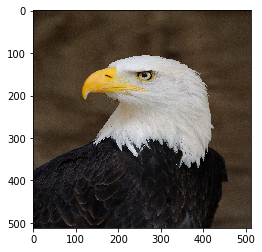

In [51]:
plt.imshow(np.round(deprocess(processed_golden_gate)[0])/255)

In [52]:

base_model= make_model()

In [53]:
golden_gate_outputs = base_model(processed_golden_gate)
wave_outputs = base_model(processed_wave)

In [54]:
golden_gate_content = golden_gate_outputs[0]
wave_content = wave_outputs[0]

In [55]:

def get_content_loss(new_image_content,base_image_content):
    return np.mean(np.square(new_image_content-base_image_content))

In [56]:

def get_gram_matrix(output):
    first_style_layer = output
    A = tf.reshape(first_style_layer,(-1,first_style_layer.shape[-1])) 
    n = A.shape[0]
    gram_matrix = tf.matmul(A,A,transpose_a=True)
    n=gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n

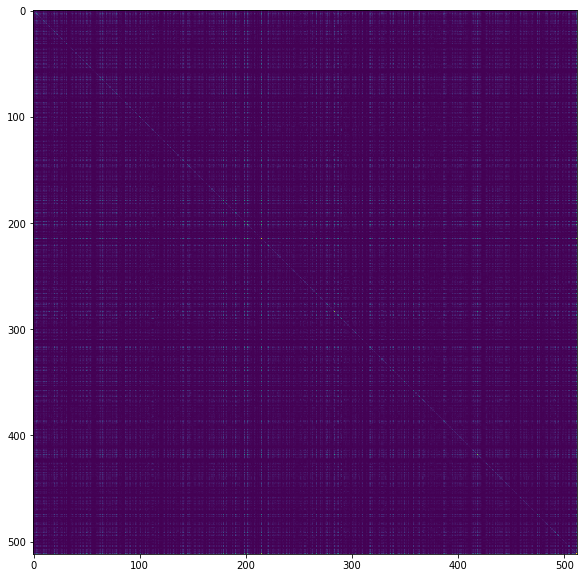

In [57]:
gram_matrix,N = get_gram_matrix(wave_outputs[2])
plt.figure(figsize=(10,10))
plt.imshow(gram_matrix.numpy());

In [58]:
def get_style_loss(new_image_style,base_style):
    new_style_gram,gram_num_height = get_gram_matrix(new_image_style)
    base_style_gram,gram_num_height2 = get_gram_matrix(base_style)
    assert gram_num_height == gram_num_height2
    gram_num_features = new_style_gram.shape[0]
    loss=tf.reduce_sum(tf.square(base_style_gram-new_style_gram)/(4*(gram_num_height**2)*(gram_num_features**2)))
    return loss

In [59]:

def get_total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.999):
    new_image_styles = new_image_output[len(CONTENT_LAYERS):]
    base_image_styles = base_style_image_output[len(CONTENT_LAYERS):]
    style_loss=0
    N = len(new_image_styles)
    for i in range(N):
        style_loss+=get_style_loss(new_image_styles[i],base_image_styles[i])
    
    new_image_contents = new_image_output[:len(CONTENT_LAYERS)]
    base_image_contents = base_content_image_output[:len(CONTENT_LAYERS)]
    content_loss = 0
    N = len(new_image_contents)
    for i in range(N):
        content_loss+=get_content_loss(new_image_contents[i],base_image_contents[i])/N
    
    return (1-alpha)*style_loss+alpha*content_loss

In [60]:
get_total_loss(wave_outputs,golden_gate_outputs,wave_outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=3566.573>

In [61]:
base_style_outputs = base_model(processed_wave)

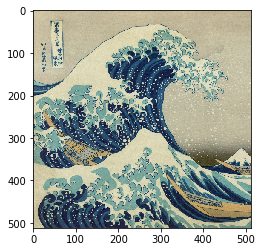

In [62]:

plt.imshow(deprocess(processed_wave)[0]/255)

In [63]:

base_content_output = base_model(processed_golden_gate)

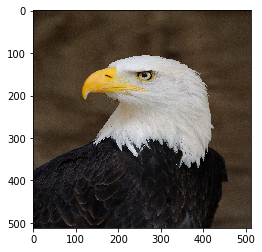

In [64]:
plt.imshow(deprocess(processed_golden_gate)[0]/255)

In [65]:
processed_content_var = tf.Variable(processed_golden_gate+tf.random.normal(processed_golden_gate.shape))

In [66]:
optimizer = tf.optimizers.Adam(5,beta_1=.99,epsilon=1e-3)

In [67]:
from IPython.display import display,clear_output

In [68]:
images = []
losses =[]

In [69]:

i=0
best_loss =25000
min_vals = VGG_BIASES
max_vals = 255+VGG_BIASES 
for i in range(200):   
    with tf.GradientTape() as tape:
        tape.watch(processed_content_var)
        content_var_outputs = base_model(processed_content_var)
        loss = get_total_loss(content_var_outputs,base_content_output,base_style_outputs,alpha=.97)
        grad = tape.gradient(loss,processed_content_var)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[processed_content_var]))
        clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
        processed_content_var.assign(clipped)
        if i%5 ==0:
            images.append(deprocess(processed_content_var))
        if loss<best_loss:
            best_image = processed_content_var
            best_loss=loss
        display(loss)
        clear_output(wait=True)

<tf.Tensor: shape=(), dtype=float32, numpy=4882.994>

In [70]:
deprocessed_best_image = deprocess(best_image)

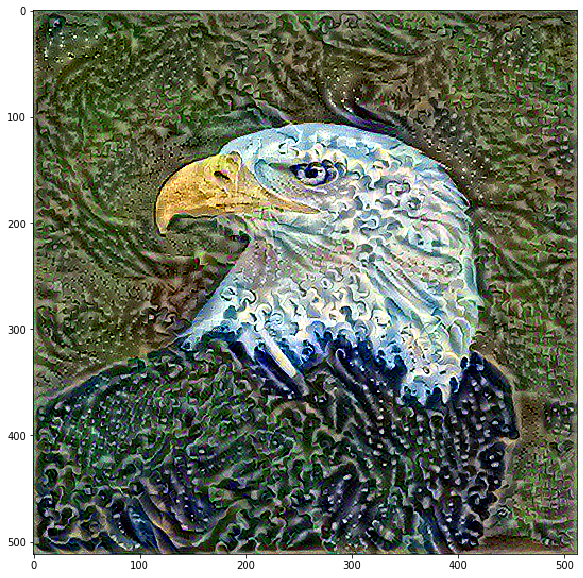

In [71]:

plt.figure(figsize=(10,10))
plt.imshow(deprocessed_best_image[0]/255)